In [2]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import time
import argparse
import os
import rasterio
import sys
from tqdm import tqdm 

In [3]:
from scripts.model import *
from scripts.utils import jaccard_index_prob, jaccard_loss, mcc, f1_score, overall_accuracy
from scripts.utils import TIFDataset, ToTensor

In [4]:
# Set variables
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = 'output/models/model_42827545_bs8_lr0.0002_epochs100_bands5_jaccard_loss.pth'
val_set_path = '/Users/bgl/Ensta/3a/pfe/data/validation-ontario'

# Load model
model = UNet(n_channels=5, n_classes=1).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

In [5]:
# Load data. Dataloader ?
bands3 = ['B2', 'B3', 'B4']
bands5 = ['B2', 'B3', 'B4', 'B8', 'ndvi']
bands9 = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'ndvi']
bands16 = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'ndvi', 'elev', 'slope']
bands = bands5
val_dataset = TIFDataset(val_set_path, transform=ToTensor(), selected_bands=bands)
valloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
print('Validation set loaded.')

Validation set loaded.


In [49]:
# Evaluate model
model.eval()
jaccard_index = 0
mcc_score = 0
f1 = 0
oa = 0
with torch.no_grad():
    for i, data in enumerate(valloader):
        inputs, labels = data['image'], data['label']
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)
        jaccard_index += jaccard_index_prob(outputs, labels)
        mcc_score += mcc(outputs, labels)
        f1 += f1_score(outputs, labels)
        oa += overall_accuracy(outputs, labels)
        print(f'Image {i+1} done.')
        
        #print(jaccard_index_prob(outputs, labels))
        
        # Check if labels is not NaN
        if torch.isnan(labels).any():
            print('Labels contains NaN')
            print(labels)
            print(data['name'])
            
        if torch.isnan(inputs).any():
            print('Inputs contains NaN')
            print(inputs)
            
        
print('Len valloader :', len(valloader))
jaccard_index /= len(valloader)
mcc_score /= len(valloader)
f1 /= len(valloader)
oa /= len(valloader)
print(f'Jaccard index: {jaccard_index}')
print(f'MCC: {mcc_score}')
print(f'F1 score: {f1}')
print(f'Overall accuracy: {oa}')



Image 1 done.
Image 2 done.
Image 3 done.
Image 4 done.
Image 5 done.
Image 6 done.
Image 7 done.
Image 8 done.
Image 9 done.
Image 10 done.
Image 11 done.
Image 12 done.
Image 13 done.
Image 14 done.
Image 15 done.
Image 16 done.
Image 17 done.
Image 18 done.
Image 19 done.
Image 20 done.
Image 21 done.
Image 22 done.
Image 23 done.
Image 24 done.
Image 25 done.
Image 26 done.
Image 27 done.
Image 28 done.
Image 29 done.
Image 30 done.
Image 31 done.
Image 32 done.
Image 33 done.
Image 34 done.
Image 35 done.
Image 36 done.
Image 37 done.
Image 38 done.
Image 39 done.
Image 40 done.
Image 41 done.
Image 42 done.
Image 43 done.
Image 44 done.
Image 45 done.
Image 46 done.
Image 47 done.
Image 48 done.
Image 49 done.
Image 50 done.
Image 51 done.
Image 52 done.
Image 53 done.
Image 54 done.
Image 55 done.
Image 56 done.
Image 57 done.
Image 58 done.
Image 59 done.
Image 60 done.
Image 61 done.
Image 62 done.
Image 63 done.
Image 64 done.
Image 65 done.
Image 66 done.
Image 67 done.
Imag

In [6]:
# TODO : count the number of images with no hedgerow label
counter = 0
for i, data in enumerate(valloader):
    labels = data['label']
    if labels.sum() == 0:
        counter += 1
print(f'Number of images with no hedgerow label: {counter}')


Number of images with no hedgerow label: 543


In [66]:
# Visualize results
def try_model(model, img_path, eval_metric, selected_bands):
    """
    Display one test image, the corresponding ground truth, and the model prediction
    """
    with rasterio.open(img_path) as src:
        # Read the image data
        raster = src.read()
        # Read the image metadata
        band_names = src.descriptions

    # Extract input channels
    indices = [band_names.index(band) for band in selected_bands]
    image = raster[indices, :, :].astype(np.float32)
    label = raster[-1, :, :].astype(np.float32)

    image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension
    label_tensor = torch.tensor(label, dtype=torch.float32).unsqueeze(0).to(device)

    # Perform forward pass
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        score = eval_metric(output, label_tensor).item()
        print('Score (Jaccard index) :', score)

    # Post-process the output (e.g., thresholding)
    threshold = 0.3
    output_thresh = (torch.sigmoid(output) > threshold).float()

    # Convert output to numpy array for visualization
    output_thresh_np = output_thresh.squeeze().cpu().numpy()
    output_np = output.squeeze().cpu().numpy()

    # Build an image with TP, TF, FP, FN
    # Initialize an RGB image with the same height and width, and 3 channels for RGB
    results = np.zeros((256, 256, 3), dtype=np.uint8)

    # Define the colors
    color_tp = [200, 255, 200]  # Green for true positives
    color_fn = [0, 0, 255]  # Blue for false negatives
    color_fp = [255, 0, 0]  # Red for false positives
    color_tn = [0, 0, 0]  # Black for true negatives

    # Create the image
    for i in range(256):
        for j in range(256):
            if output_thresh_np[i, j] == 1 and label[i, j] == 1:
                results[i, j] = color_tp
            elif output_thresh_np[i, j] == 0 and label[i, j] == 1:
                results[i, j] = color_fn
            elif output_thresh_np[i, j] == 1 and label[i, j] == 0:
                results[i, j] = color_fp
            elif output_thresh_np[i, j] == 0 and label[i, j] == 0:
                results[i, j] = color_tn


    # Get RGB composite
    rgb_indices = [band_names.index(band) for band in ['B4', 'B3', 'B2']]
    rgb = raster[rgb_indices, :, :].astype(np.float32)
    
    def adjust_gamma_band(image_band, gamma):
        # Apply gamma correction (non-linear transformation) for a single band
        return np.power(image_band, gamma)
    
    rgb_gamma = np.stack([adjust_gamma_band(rgb[:,:,0], 1.3), rgb[:,:,1], rgb[:,:,2]], axis=2)

    mx = 0.3 #np.max(rgb)
    rgb = (rgb) / (mx)

    # Display input RGB image, labels, and predictions
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs[0, 0].imshow(rgb.transpose(1, 2, 0))
    axs[0, 0].set_title('Input Image')
    axs[1, 0].imshow(label, cmap='gray')
    axs[1, 0].set_title('Ground Truth')
    axs[1, 1].imshow(output_thresh_np, cmap='gray')
    axs[1, 1].set_title('Prediction')
    axs[0, 1].imshow(results)
    axs[0, 1].set_title('Confusion Matrix')
    plt.show()
    plt.close(fig)

Score (Jaccard index) : nan


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.114333324..1.7733333].


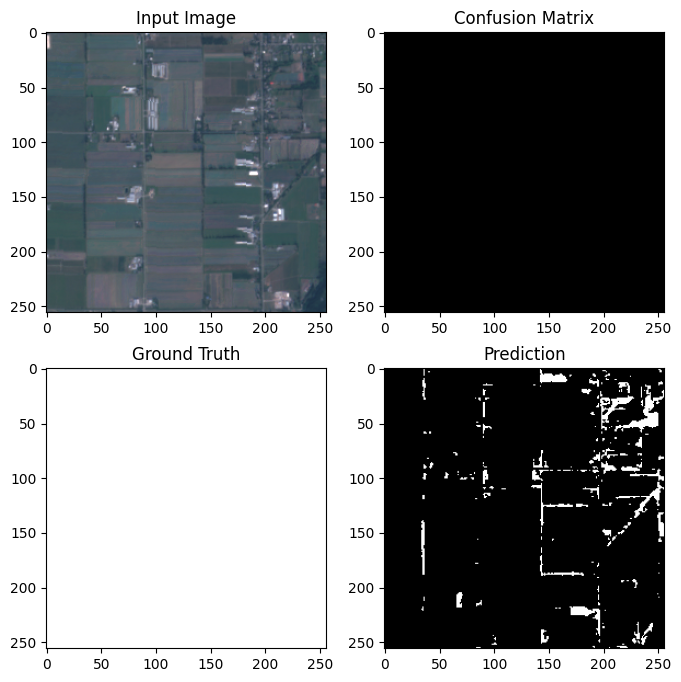

In [71]:
img_path = '/Users/bgl/Ensta/3a/pfe/data/bc-examples/img0002.tif'

try_model(model, img_path, jaccard_index_prob, bands5)